# CATE estimation with observational data (confounders)
Here, we explore the effectiveness of different scoring metrics in capturing the error between the estimated and true causal effects in small synthetic datasets of observational data.  
In contrast to the RCT notebook, here we assume that the covariates influence the outcome, as well as the treatment assignment. In other words, treatments are confounded by the covariates.  

## Background
Often, different units are suceptible to a treatment to different degrees. Our goal is to use our toolbox to estimate these heterogenous treatment effects and assess how well the toolbox performs
In other words, how well does a score reflect the mismatch between the estimated and true causal effect?  
We divide our approach in different parts. First, we'll generate some synthetic data for which we know the relationship between variables, as well as the treatment effect.   
We'll use CausalTune for hyperparameter tuning and model selection of a zoo of causal estimators. We'll do this for different scoring methods.
Lastly, we'll plot the returned scores against the misestimation error between predicted and true treatment effect. 
Below, we import the relevant modules and define a few helper functions (TODO outsource the latter to causaltune, once approved)

In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import copy
warnings.filterwarnings('ignore') # suppress sklearn deprecation warnings for now..
try:
    import graphviz
except ModuleNotFoundError as e:
    import pip
    pip.main(["install","graphviz"])
    import graphviz

from typing import Union

root_path = root_path = os.path.realpath('../../..')
try:
    import causaltune
except ModuleNotFoundError:
    sys.path.append(os.path.join(root_path, "causaltune"))

from sklearn.model_selection import train_test_split
from causaltune import CausalTune
from causaltune.data_utils import CausalityDataset
from causaltune.datasets import generate_synthetic_data


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [12]:
# set a few params
metrics = [
    "norm_erupt", 
    #"qini",
    "energy_distance", 
    "psw_energy_distance"
    ]
n_samples = 10000
test_size = 0.33 # equal train,val,test
components_time_budget = 30
estimator_list = "auto"
n_runs = 1
out_dir = "../data/"
filename_out = "synthetic_observational_cate_24h" 


We will simulate data in which the outcome is influenced by the treatment and a set of covariates, which influence both the treatment and the outcome (hence they are confounders)

In [5]:
dot = graphviz.Digraph("causal-graph",comment="A simple causal graph with confounders",filename="observational_cate_graph.gv")
dot.attr(rank="same")
with dot.subgraph(name="cluster_0") as c:
    c.attr(color="white")
    c.node("X",label="Covariates")
dot.node("Y",label="Outcome")
dot.edge("X","Y")
with dot.subgraph(name="cluster_1") as d:
    d.attr(color="white")
    d.node("T",label="Treatment")
dot.edge("T","Y")
dot.edge("X","T")
dot.edge_attr.update(arrowsize="1")
dot

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

### 1.1 Dataset generation

Let $X^{Nxd}$ be the matrix of $N$ observations and $d$ covariates, $T^{nx1}$ the vector of treatment assignments and $Y^{nx1}$ the vector of outcomes. 
We make the following assumptions:  
- binary treatments
- treatment allocation depends on the confounding covariates
- five continuous, normally distributed covariates
- no interaction between treatment effects and covariates
- independence of the covariates, i.e. $\Sigma = \sigma^2I$
- no additive noise in the outcomes, i.e. $\epsilon=0$

  
Then, the data is generated according to the following equations:
\begin{align*}
& X_i \sim \mathcal{N}(0,\Sigma) \\\\
& T_i \sim Bernoulli \left( \frac{1}{1+exp(X_{i,1} \otimes X_{i,2} + 3*X_{i,3})} \right) \\\\
& Y_i = \tau(X_i) T_i + \mu_0(X_i) + \epsilon
\end{align*}
where $i$ indexes individual units, $\tau$ describes the following true treatment effect, which depends linearly on all covariates:
\begin{equation*}
\tau(X_i) = X_ib^T + e
\end{equation*}
where $b$ is a 1xd vector of $b_i \sim U(0.4,0.7)$ weights for each covariate and $e \sim \mathcal{N}(0,0.05)$ gaussian noise.  
... and  $\mu_0(x)$ describes the following transformation of the covariates (to keep things interesting):
\begin{equation*}
\mu_0(X_i) = X_{i,1} \otimes X_{i,2} + X_{i,3} + X_{i,4} \otimes X_{i,5} 
\end{equation*}




### 1.2 Preprocessing
Now we apply CausalTune's built-in preprocessing pipeline and construct train/val/test sets

In [17]:
cd = generate_synthetic_data(n_samples=n_samples, confounding=True, linear_confounder=True, noisy_outcomes=True)
cd.preprocess_dataset()
# drop true effect:
features_X = [f for f in cd.common_causes if f != "true_effect"]
print(f"Common causes: {cd.common_causes}")
print(f"Effect modifieres: {cd.effect_modifiers}")
cd.data.head(10)


0.1 0.9
Common causes: ['random']
Effect modifieres: ['X1', 'X2', 'X3', 'X4', 'X5']


,treatment,outcome,true_effect,base_outcome,random,X1,X2,X3,X4,X5,propensity
0,0,46.522817,1.259841,46.522817,1.0,4.358412,4.640428,2.992681,-6.513875,-3.580477,0.100000
1,1,-13.380595,-6.542663,-6.837933,0.0,2.274155,-3.627609,-4.091029,-1.763242,-3.142666,0.900000
2,0,2.024434,5.240059,2.024434,0.0,0.044463,5.724030,1.704938,0.100119,1.025647,0.100000
3,1,-9.628600,-2.208974,-7.419625,0.0,1.334620,-3.915256,-1.694219,-0.434933,1.039078,0.900000
4,0,2.427882,-3.900061,2.427882,0.0,-2.364758,-0.931077,-1.404292,-2.592421,-0.607365,0.881958
5,0,4.410602,4.503386,4.410602,0.0,4.185138,0.803670,0.082910,0.286045,3.025235,0.100000
6,1,-6.813986,-8.617617,1.803631,0.0,-10.579535,-0.131112,-2.431625,-5.113391,-0.548003,0.900000
7,0,6.030843,-1.284523,6.030843,0.0,-1.799362,0.058508,2.295016,-2.950954,-1.279643,0.100000
8,0,11.971066,4.640946,11.971066,0.0,0.421993,0.819656,0.133768,3.266666,3.514631,0.321433
9,0,9.202992,5.583203,9.202992,0.0,3.786350,1.632104,1.640742,0.582381,2.451236,0.100000


### 1.3 Model fitting
Now we're ready to find the best fitting model, given a user-specified metric. As we'd like to compare different metrics, we'll be doing this in a for-loop

In [18]:

models = []

for i_run in range(1,n_runs+1):
    
    cd_i = copy.deepcopy(cd)
    train_df, test_df = train_test_split(cd_i.data, test_size=test_size)
    test_df = test_df.reset_index(drop=True)
    cd_i.data = train_df
    
    for metric in metrics:
        ct = CausalTune(
            metric=metric,
            verbose=1,
            propensity_model='auto',
            components_verbose=1,
            components_time_budget=components_time_budget,
            estimator_list=estimator_list,
            store_all_estimators=True,
        )

        ct.fit(
            data=cd_i,
            treatment="treatment",
            outcome="outcome",
        )

        # compute relevant scores (skip newdummy)
        datasets = {"train": ct.train_df, "validation": ct.test_df, "test": test_df}
        # get scores on train,val,test for each trial, 
        # sort trials by validation set performance
        # assign trials to estimators
        estimator_scores = {est: [] for est in ct.scores.keys() if "NewDummy" not in est}
        for trial in ct.results.trials:
            # estimator name:
            estimator_name = trial.last_result["estimator_name"]
            if  trial.last_result["estimator"]:
                estimator = trial.last_result["estimator"]
                scores = {}
                for ds_name, df in datasets.items():
                    scores[ds_name] = {}
                    # make scores
                    est_scores = ct.scorer.make_scores(
                        estimator,
                        df,
                        metrics_to_report=ct.metrics_to_report,
                    )

                    # add cate:
                    scores[ds_name]["CATE_estimate"] = estimator.estimator.effect(df)
                    # add ground truth for convenience
                    scores[ds_name]["CATE_groundtruth"] = df["true_effect"]
                    scores[ds_name][metric] = est_scores[metric]
                estimator_scores[estimator_name].append(scores)


        # sort trials by validation performance
        for k in estimator_scores.keys():
            estimator_scores[k] = sorted(
                estimator_scores[k],
                key=lambda x: x["validation"][metric],
                reverse=False if metric in ["energy_distance", "psw_energy_distance"] else True,
            )
        results = {
            "best_estimator": ct.best_estimator,
            "best_config": ct.best_config,
            "best_score": ct.best_score,
            "optimised_metric": metric,
            "scores_per_estimator": estimator_scores,
        }


        with open(f"{out_dir}{filename_out}_{metric}_run_{i_run}.pkl", "wb") as f:
            pickle.dump(results, f)
        
        models.append(ct)




Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks


[flaml.tune.tune: 08-09 12:53:15] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 08-09 12:53:15] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}


Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': Tru

[flaml.tune.tune: 08-09 12:53:15] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 08-09 12:53:46] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 08-09 12:54:17] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 08-09 12:56:18] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}}
[flaml.tune.tune: 08-09 12:58:19] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': 1, 'n_estimators': 100, 'criteri

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks


[flaml.tune.tune: 08-09 13:04:01] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 08-09 13:04:01] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}


Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': Tru

[flaml.tune.tune: 08-09 13:04:01] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 08-09 13:04:32] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 08-09 13:05:02] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 08-09 13:07:03] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}}
[flaml.tune.tune: 08-09 13:09:04] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': 1, 'n_estimators': 100, 'criteri

Fitting a Propensity-Weighted scoring estimator to be used in scoring tasks


[flaml.tune.tune: 08-09 13:14:41] {493} WARNING - Using CFO for search. To use BlendSearch, run: pip install flaml[blendsearch]
[flaml.tune.tune: 08-09 13:14:41] {636} INFO - trial 1 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}


Initial configs: [{'estimator': {'estimator_name': 'backdoor.causaltune.models.NaiveDummy'}}, {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}, {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': True, 'subforest_size': 4}}, {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': True, 'n_estimators': 100, 'criterion': 'mse', 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': Tru

[flaml.tune.tune: 08-09 13:14:42] {636} INFO - trial 2 config: {'estimator': {'estimator_name': 'backdoor.causaltune.models.Dummy'}}
[flaml.tune.tune: 08-09 13:15:13] {636} INFO - trial 3 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.SLearner'}}
[flaml.tune.tune: 08-09 13:15:44] {636} INFO - trial 4 config: {'estimator': {'estimator_name': 'backdoor.econml.metalearners.DomainAdaptationLearner'}}
[flaml.tune.tune: 08-09 13:17:45] {636} INFO - trial 5 config: {'estimator': {'estimator_name': 'backdoor.econml.dr.ForestDRLearner', 'min_propensity': 1e-06, 'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.0, 'max_features': 'auto', 'min_impurity_decrease': 0.0, 'max_samples': 0.45, 'min_balancedness_tol': 0.45, 'honest': 1, 'subforest_size': 4}}
[flaml.tune.tune: 08-09 13:19:46] {636} INFO - trial 6 config: {'estimator': {'estimator_name': 'backdoor.econml.dml.CausalForestDML', 'drate': 1, 'n_estimators': 100, 'criteri

In [13]:

for i_run in range(1,n_runs+1):

    train_df, test_df = train_test_split(data_df, test_size=test_size)
    test_df = test_df.reset_index(drop=True)
    
    for metric in metrics:
        try:
            ct = CausalTune(
                metric=metric,
                verbose=1,
                components_verbose=1,
                components_time_budget=components_time_budget,
                estimator_list=estimator_list,
                store_all_estimators=True,
                propensity_model="auto",
            )

            ct.fit(
                train_df,
                treatment="treatment",
                outcome="outcome",
                common_causes=features_W,
                effect_modifiers=features_X,
            )
            
            # compute relevant scores (skip newdummy)
            datasets = {"train": ct.train_df, "validation": ct.test_df, "test": test_df}
            # get scores on train,val,test for each trial, 
            # sort trials by validation set performance
            # assign trials to estimators
            estimator_scores = {est: [] for est in ct.scores.keys() if "NewDummy" not in est}
            for trial in ct.results.trials:
                # estimator name:
                estimator_name = trial.last_result["estimator_name"]
                if  trial.last_result["estimator"]:
                    estimator = trial.last_result["estimator"]
                    scores = {}
                    for ds_name, df in datasets.items():
                        scores[ds_name] = {}
                        # make scores
                        est_scores = ct.scorer.make_scores(
                            estimator,
                            df,
                            problem=ct.problem,
                            metrics_to_report=ct.metrics_to_report,
                        )

                        # add cate:
                        scores[ds_name]["CATE_estimate"] = estimator.estimator.effect(df)
                        # add ground truth for convenience
                        scores[ds_name]["CATE_groundtruth"] = df["true_effect"]
                        scores[ds_name][metric] = est_scores[metric]
                    estimator_scores[estimator_name].append(scores)


            # sort trials by validation performance
            for k in estimator_scores.keys():
                estimator_scores[k] = sorted(
                    estimator_scores[k],
                    key=lambda x: x["validation"][metric],
                    reverse=False if metric == "energy_distance" else True,
                )
            results = {
                "best_estimator": ct.best_estimator,
                "best_config": ct.best_config,
                "best_score": ct.best_score,
                "optimised_metric": metric,
                "scores_per_estimator": estimator_scores,
            }


            with open(f"{out_dir}{filename_out}_{metric}_run_{i_run}.pkl", "wb") as f:
                pickle.dump(results, f)
        except:
            pass



NameError: name 'data_df' is not defined

### 1.4 Evaluation
How well did the different metrics quantify the mismatch between estimated and true treatment effects?

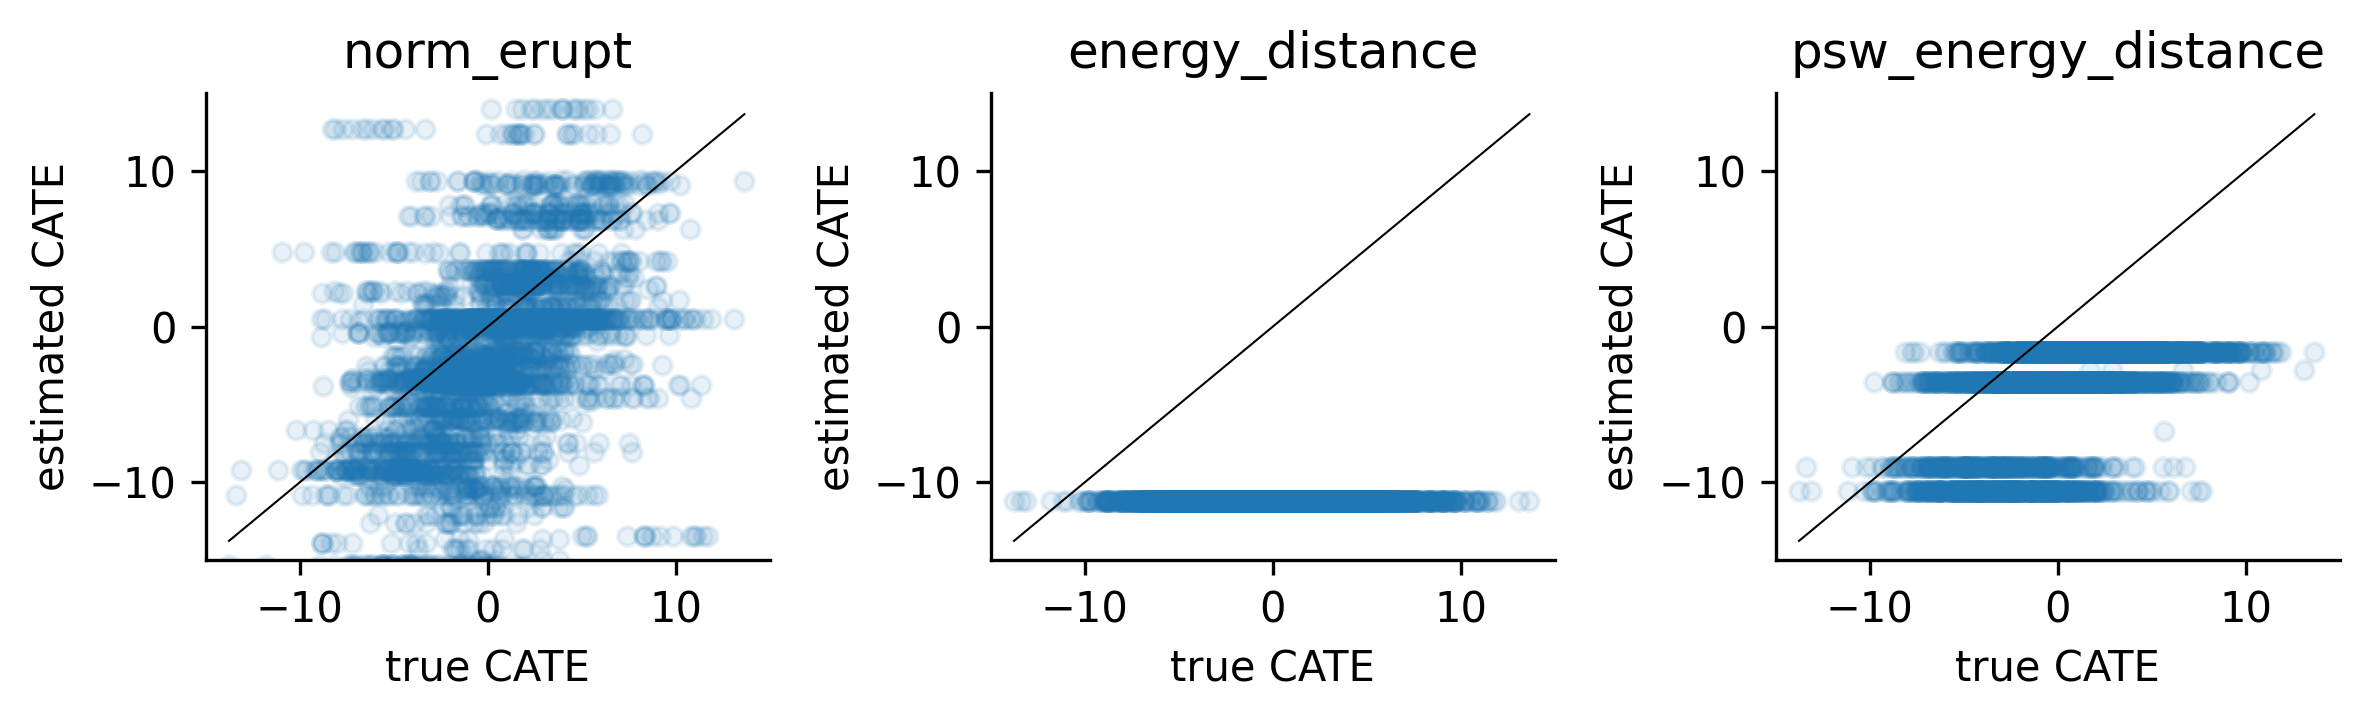

In [24]:
%matplotlib inline
f, axs = plt.subplots(1,len(metrics),figsize=(8,2.5),dpi=300)


# plot true against estimated for best estimator:
for ax, metric in zip(axs, metrics):
    try:
        with open(f"{out_dir}{filename_out}_{metric}_run_1.pkl","rb") as f:
            results = pickle.load(f)
        CATE_gt = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_groundtruth"]
        CATE_est = results["scores_per_estimator"][results["best_estimator"]][0]["test"]["CATE_estimate"]
        

        ax.scatter(CATE_gt,CATE_est,s=20,alpha=0.1)        
        ax.plot([min(CATE_gt),max(CATE_gt)],[min(CATE_gt),max(CATE_gt)],"k-",linewidth=0.5)
        ax.set_xlabel("true CATE")
        ax.set_ylabel("estimated CATE")
        ax.set_title(f"{results['optimised_metric']}")
        ax.set_xlim([-15,15])
        ax.set_ylim([-15,15])
        # ax.set_xticks(np.arange(-0.5,0.51,0.5))
        # ax.set_yticks(np.arange(-0.5,0.51,0.5))
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    except:
        pass
plt.tight_layout() 

In [28]:
import colorsys

def scale_lightness(rgb, scale_l):
    # found here https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
    # convert rgb to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)
    # manipulate h, l, s values and return as rgb
    return colorsys.hls_to_rgb(h, min(1, l * scale_l), s = s)

backdoor.econml.dr.LinearDRLearner: 4 intermediate runs 
backdoor.econml.dr.LinearDRLearner: 4 intermediate runs 
backdoor.econml.dr.LinearDRLearner: 5 intermediate runs 


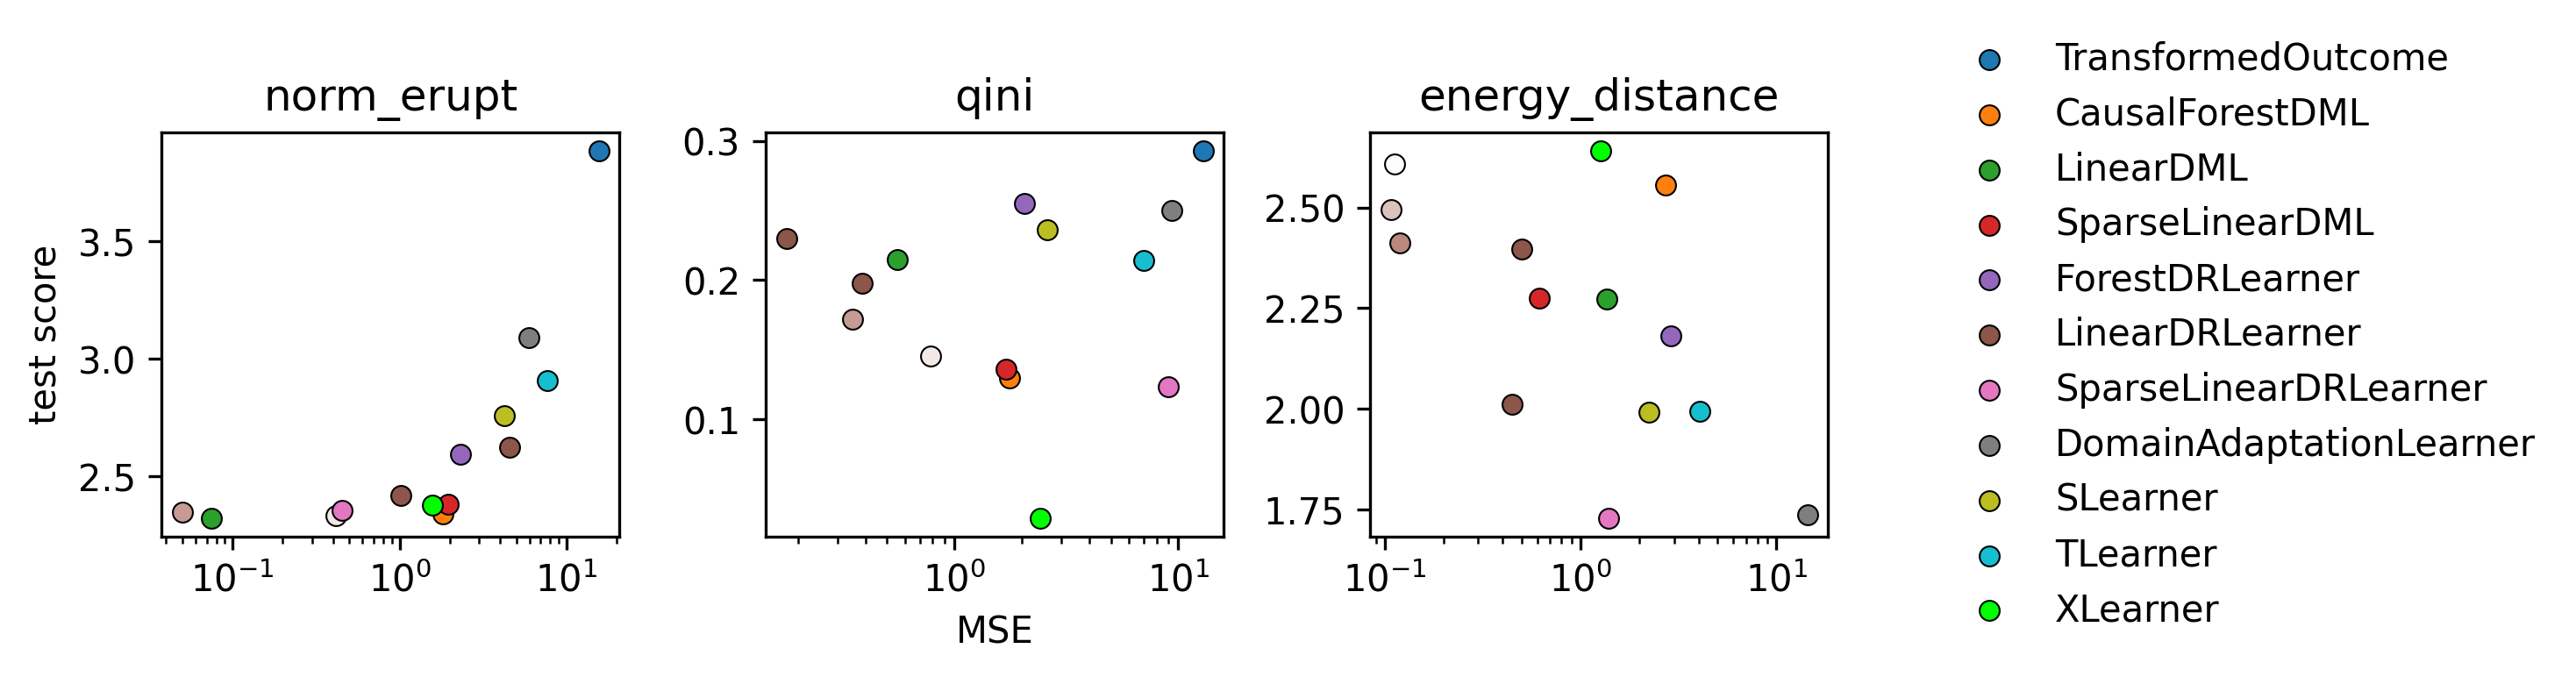

In [32]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

colors = ([matplotlib.colors.CSS4_COLORS['black']] +
    list(matplotlib.colors.TABLEAU_COLORS) + [
    matplotlib.colors.CSS4_COLORS['lime'],
    matplotlib.colors.CSS4_COLORS['yellow'],
    matplotlib.colors.CSS4_COLORS['pink']
])

f, axs = plt.subplots(1,len(metrics),figsize=(10,2.5),dpi=300)

est_labels = [[], [], []]
sc = [[], [], []]
for i, (ax,metric) in enumerate(zip(axs, metrics)):
    with open(f"{out_dir}{filename_out}_{metric}_run_1.pkl","rb") as f:
        results = pickle.load(f)
    
    for (est_name, scr), col in zip(results["scores_per_estimator"].items(),colors):                  
        if "Dummy" not in est_name:
            if len(scr):
                # also plot intermediate runs:
                if len(scr) > 1:
                    print(f"{est_name}: {len(scr)} intermediate runs ")
                    lightness = np.linspace(1,2.8,len(scr))
                    
                    col_rgb = matplotlib.colors.ColorConverter.to_rgb(col)
                    for i_run in range(1,len(scr)):
                        CATE_gt = scr[i_run]["test"]["CATE_groundtruth"]
                        CATE_est = scr[i_run]["test"]["CATE_estimate"]
                        mse=np.mean((CATE_gt-CATE_est)**2)
                        score = scr[i_run]["test"][metric]
                        ax.scatter(mse,score,color=scale_lightness(col_rgb,lightness[i_run-1]),s=30,edgecolors="k",linewidths=0.5)
                # get score for best estimator:
                CATE_gt = scr[0]["test"]["CATE_groundtruth"]
                CATE_est = scr[0]["test"]["CATE_estimate"]
                mse=np.mean((CATE_gt-CATE_est)**2)
                score = scr[0]["test"][metric]
                sc[i].append(ax.scatter(mse,score,color=col,s=30,edgecolors="k",linewidths=0.5))
                est_labels[i].append(est_name.split(".")[-1])
    if i is 1:
        ax.set_xlabel("MSE")    
    if i is 0:
        ax.set_ylabel("test score") 
    ax.set_title(metric)
    ax.set_xscale("log")    
    # ax.set_xlim(1*10**0,3*10**1)
    
ax.legend(sc[0],est_labels[0],loc='center left', bbox_to_anchor=(1.2, 0.5),frameon=False)
plt.tight_layout()
